In [1]:
import scanpy as sc
import sys
sys.path.append(r"D:\Scunpair_Project\Diagonal-integration")
import mycode
adata_RNA = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\scRNA+scATAC mouse brain\adata_rna.h5ad")
adata_ATAC = sc.read_h5ad(r"D:\Scunpair_Project\Dataset\scRNA+scATAC mouse brain\adata_atac.h5ad")

In [2]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_ATAC.var_names) & set(adata_RNA.var_names)))
adata_RNA = adata_RNA[:, cm_genes]
adata_ATAC = adata_ATAC[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = adata_RNA.var_names[adata_RNA.var.highly_variable | adata_ATAC.var.highly_variable]
shared_genes = list(shared_genes)

adata_RNA = adata_RNA[:,shared_genes].copy()
adata_ATAC = adata_ATAC[:,shared_genes].copy()

sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_total(adata_ATAC)
sc.pp.log1p(adata_ATAC)

sc.pp.scale(adata_RNA, max_value=10)
sc.pp.scale(adata_ATAC, max_value=10)
'''
adata_RNA.obs['batch'] = adata_RNA.obs['Tissue']
mycode.utils.batch_scale(adata_RNA)
mycode.utils.batch_scale(adata_ATAC)
'''
sc.pp.pca(adata_RNA)
sc.pp.pca(adata_ATAC)

adata_RNA.obsm['link_feat'] = adata_RNA.obsm['X_pca']
adata_ATAC.obsm['link_feat'] = adata_ATAC.obsm['X_pca']

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:174: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
model = mycode.Model(adata_RNA, adata_ATAC, batch_size=500, 
                           training_steps=10001, seed=1234, celltype_col='celltype',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaAlign = 1.0, lambdamGAN = 1.0, lambdabGAN = 0.0, lambdaGeo=0.5, n_KNN = 30, mode = 'strong', use_prior = False, link_feat_num = 1000)

In [4]:
model.train()
model.eval()

Training started at: Sat Sep 27 08:40:24 2025
Step 0 | loss_Recon: 17.7694 | loss_LA: 43.2948 | loss_Align: 0.9302 | loss_Geo: 0.4319 | loss_mGAN vs loss_mDis: -1.3569 vs 1.3871 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_Recon: 12.7984 | loss_LA: 0.0601 | loss_Align: 0.0441 | loss_Geo: 0.0236 | loss_mGAN vs loss_mDis: -1.3393 vs 1.3431 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 2000 | loss_Recon: 12.3367 | loss_LA: 0.0477 | loss_Align: 0.0424 | loss_Geo: 0.0217 | loss_mGAN vs loss_mDis: -1.3348 vs 1.3375 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 3000 | loss_Recon: 12.3904 | loss_LA: 0.0436 | loss_Align: 0.0429 | loss_Geo: 0.0233 | loss_mGAN vs loss_mDis: -1.3216 vs 1.3260 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 4000 | loss_Recon: 11.9431 | loss_LA: 0.0427 | loss_Align: 0.0422 | loss_Geo: 0.0223 | loss_mGAN vs loss_mDis: -1.2985 vs 1.3019 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 5000 | loss_Recon: 11.7337 | loss_LA: 0.0443 | loss_Align: 0.

In [5]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_ATAC.shape[0]

In [6]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


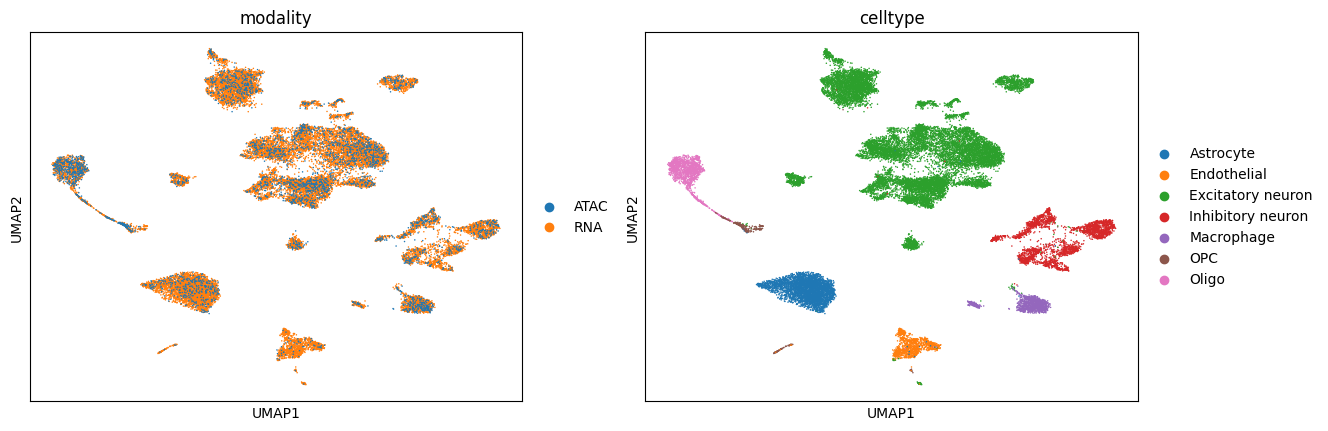

In [7]:
sc.pl.umap(adata_integrated, color=['modality','celltype'])

In [10]:
model.E_B

DomainWrapper(
  (model): Encoder(
    (base): BaseBlock(
      (fc): Linear(in_features=1002, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (fc_mu): Linear(in_features=512, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=16, bias=True)
    (bn_A): Identity()
    (bn_B): Identity()
  )
)

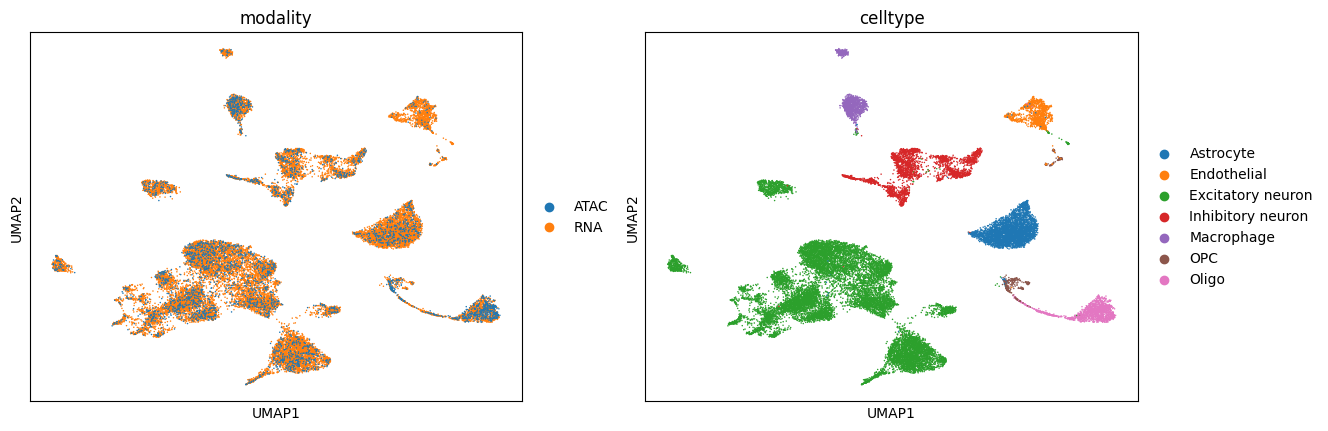

In [7]:
sc.pl.umap(adata_integrated, color=['modality','celltype'])

In [ ]:
adata_RNA.obs['Class']

CellID
10X22_2_AGTTCTTGGTCGAT-1        Oligos
10X28_3_CTCGCATGGCAGAG-1        Oligos
10X28_2_TTTAGGCTATTCCT-1        Oligos
10X28_2_CGTGATGAGGAACG-1        Oligos
10X28_2_ACATGGTGGAATGA-1        Oligos
                               ...    
10X35_1_GAGGGATGTCCC-       Astrocytes
10X35_1_CTGTCTTGAGCT-       Astrocytes
10X20_2_TAGAAACTCTTCCG-1    Astrocytes
10X35_1_TCAAGACTCGAA-       Astrocytes
10X19_2_CGATCAGAGAATCC-1    Astrocytes
Name: Class, Length: 22296, dtype: category
Categories (5, object): ['Astrocytes', 'Immune', 'Neurons', 'Oligos', 'Vascular']